In [47]:
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

## Reducers
from typing import Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage

In [48]:
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [49]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["LANGCHAIN_TRACING"]=os.getenv("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_ENDPOINT"]= os.getenv("LANGSMITH_ENDPOINT")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGSMITH_TRACING")
os.environ["LANGCHAIN_PROJECT"]=os.getenv("LANGSMITH_PROJECT")
os.environ["GROQ_API_KEY"] =os.getenv("GROQ_API_KEY")
os.environ["OPENWEATHERMAP_API_KEY"]=os.getenv("OPENWEATHERMAP_API_KEY")


In [50]:
from langchain_huggingface import HuggingFaceEmbeddings
from transformers import CLIPProcessor,CLIPModel
from PIL import Image
import base64

clip_model=CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
clip_processor=CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
clip_model.eval()

'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /openai/clip-vit-base-patch32/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x1101bd190>: Failed to resolve \'huggingface.co\' ([Errno 8] nodename nor servname provided, or not known)"))'), '(Request ID: 4fb392fc-e80a-4ca4-92db-d5b2d5c54599)')' thrown while requesting HEAD https://huggingface.co/openai/clip-vit-base-patch32/resolve/main/config.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /openai/clip-vit-base-patch32/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x1101bc4a0>: Failed to resolve \'huggingface.co\' ([Errno 8] nodename nor servname provided, or not known)"))'), '(Request ID: 032c7208-819f-4adf-ba20-23142bd44a79)')' thrown while requesting HEAD https://huggingface.co/op

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [51]:
#embedding function for images
import torch

def embed_image(image_data):
    if isinstance(image_data,str): #path
        image=Image.open(image_data).convert('RGB')
    else:
        image=image_data

    inputs=clip_processor(images=image,return_tensors='pt')
    with torch.no_grad():
        features=clip_model.get_image_features(**inputs)
        #normalize to unit vector
        features=features/features.norm(dim=-1,keepdim=True)
        return features.squeeze().numpy()
    
def embed_text(text):
    inputs=clip_processor(
        text=text,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=77
    )
    with torch.no_grad():
        features=clip_model.get_text_features(**inputs)
        #normalize to unit vector
        features=features/features.norm(dim=-1,keepdim=True)
        return features.squeeze().numpy()

In [52]:
#process pdf
import fitz #pymupdf
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.messages import HumanMessage,AIMessage
from langchain_core.prompts import ChatMessagePromptTemplate
from langchain_core.output_parsers import StrOutputParser
pdf_path='../files/gemma.pdf'
doc=fitz.open(pdf_path)


all_docs=[]
all_embeddings=[]
image_data_store={}

splitter=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=50)

In [53]:
from langchain_core.documents import Document
import io

for i,page in enumerate(doc):
    #process text 
    text=page.get_text()
    if text.strip():
        temp_doc=Document(page_content=text,metadata={'page':i,'type':'text'})
        text_chunks=splitter.split_documents([temp_doc])
        for chunk in text_chunks:
            embedding=embed_text(chunk.page_content)
            all_embeddings.append(embedding)
            all_docs.append(chunk)

    #process images
    #convert pdf images to pil
    #convert to base64
    #clip embedding for retrieval
    for img_id,img in enumerate(page.get_images(full=True)):
        try:
            xref=img[0]
            base_image=doc.extract_image(xref)
            image_bytes=base_image['image']

            #convert to pil
            pil_image=Image.open(io.BytesIO(image_bytes)).convert('RGB')

            #image identifier
            image_id=f'page_{i}_img_{img_id}'

            buffered=io.BytesIO()
            pil_image.save(buffered,format="PNG")
            image_base64=base64.b64encode(buffered.getvalue()).decode()
            image_data_store[image_id]=image_base64

            #embed using clip
            embedding=embed_image(pil_image)
            all_embeddings.append(embedding)

            #document for image
            image_doc=Document(
                page_content=f'[image:{image_id}]',
                metadata={'page':i,'type':'image','image_id':image_id}
            )
            all_docs.append(image_doc)

        except Exception as e:
            print(e,img_id)
            continue
doc.close()


In [9]:
all_docs

[Document(metadata={'page': 0, 'type': 'text'}, page_content='3/10/24, 8:32 PM\nGemma: Google introduces new state-of-the-art open models\nhttps://blog.google/technology/developers/gemma-open-models/\n1/5\nDEVELOPERS\nGemma: Introducing new state-\nof-the-art open models\nGemma is built for responsible AI development from the same research and\ntechnology used to create Gemini models.\nFeb 21, 2024 · 3 min read\nJ\nJeanine Banks\nVP & GM, Developer X and\nDevRel\nT\nTris Warkentin\nDirector, Google DeepMind\nShare\nListen to article 7 minutes\nThe Keyword'),
 Document(metadata={'page': 0, 'type': 'image', 'image_id': 'page_0_img_0'}, page_content='[image:page_0_img_0]'),
 Document(metadata={'page': 1, 'type': 'text'}, page_content='3/10/24, 8:32 PM\nGemma: Google introduces new state-of-the-art open models\nhttps://blog.google/technology/developers/gemma-open-models/\n2/5\nAt Google, we believe in making AI helpful for everyone. We have a long history of contributing innovations\nto th

In [128]:
from langchain_community.retrievers import BM25Retriever
sparse_retriever=BM25Retriever.from_documents(all_docs)
sparse_retriever.k=3

In [54]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import VectorParams, Distance, PointStruct
from langchain_qdrant import QdrantVectorStore
from langchain_core.embeddings import Embeddings
import uuid
import numpy as np

class CLIPEmbeddings(Embeddings):
    def embed_documents(self, texts):
        return [embed_text(t) for t in texts]
    def embed_query(self, text):
        return embed_text(text)

clip_embeddings = CLIPEmbeddings()

# -----------------------------
# 1️⃣ Create in-memory Qdrant
# -----------------------------
client = QdrantClient(":memory:")

collection_name = "report"

# Infer embedding size
vector_dim = len(all_embeddings[0])

# Create collection manually
client.recreate_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=vector_dim, distance=Distance.COSINE),
)

# -----------------------------
# 2️⃣ Upload existing embeddings
# -----------------------------
points = [
    PointStruct(
        id=str(uuid.uuid4()),
        vector=emb.tolist() if isinstance(emb, np.ndarray) else emb,
        payload={
            "page_content": doc.page_content,
            "metadata": doc.metadata,
        },
    )
    for doc, emb in zip(all_docs, all_embeddings)
]

client.upsert(collection_name=collection_name, points=points)

# -----------------------------
# 3️⃣ Wrap with LangChain store
# -----------------------------
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=clip_embeddings,  # since embeddings are precomputed
)



/var/folders/0p/n1mxyw8j7s56r6nh6qdnfnf40000gn/T/ipykernel_1214/4040595156.py:27: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


In [55]:
query = "which are some multiframework tools"
query_vector = embed_text(query)

results = client.search(
    collection_name=collection_name,
    query_vector=query_vector,
    with_payload=True,
    limit=5,
)

for r in results:
    print(r.payload["metadata"], "→", r.payload["page_content"][:100])
    print('-----------')

{'page': 1, 'type': 'text'} → applications with Gemma.
We’re providing toolchains for inference and supervised fine-tuning (SFT) a
-----------
{'page': 4, 'type': 'text'} → We’re excited to see what you create!
POSTED IN:
Developers
 
AI
More Information
Collapse
Google ad
-----------
{'page': 1, 'type': 'text'} → AI model widely available today. This enables Gemma 2B and 7B to achieve best-in-class performance f
-----------
{'page': 2, 'type': 'text'} → researchers prioritize building safe and responsible AI applications. The toolkit includes:
1
-----------
{'page': 1, 'type': 'text'} → with easy deployment on Vertex AI and Google Kubernetes Engine (GKE).
Optimization across multiple A
-----------


/var/folders/0p/n1mxyw8j7s56r6nh6qdnfnf40000gn/T/ipykernel_1214/3458981884.py:4: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  results = client.search(


In [56]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="openai/gpt-oss-120b")

In [57]:
retriever=vectorstore.as_retriever(search_kwargs={'k':5})

In [12]:
retriever.get_relevant_documents('what is gemma')

/var/folders/0p/n1mxyw8j7s56r6nh6qdnfnf40000gn/T/ipykernel_1214/2899309716.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retriever.get_relevant_documents('what is gemma')
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[Document(metadata={'page': 1, 'type': 'text', '_id': '648549cd-80b2-4388-bc5a-6b188a6c9dff', '_collection_name': 'report'}, page_content='AI model widely available today. This enables Gemma 2B and 7B to achieve best-in-class performance for'),
 Document(metadata={'page': 2, 'type': 'text', '_id': '572e322f-f886-494a-9079-6fc165281826', '_collection_name': 'report'}, page_content='3/10/24, 8:32 PM\nGemma: Google introduces new state-of-the-art open models\nhttps://blog.google/technology/developers/gemma-open-models/\n3/5\ntheir sizes compared to other open models. And Gemma models are capable of running directly on a\ndeveloper laptop or desktop computer. Notably, Gemma surpasses significantly larger models on key\nbenchmarks while adhering to our rigorous standards for safe and responsible outputs. See the technical'),
 Document(metadata={'page': 1, 'type': 'text', '_id': '6ace67ea-ae3a-4915-a1b7-c69319bcf16c', '_collection_name': 'report'}, page_content='3/10/24, 8:32 PM\nGemma: Goog

In [129]:
from langchain.retrievers import EnsembleRetriever

hybrid_retriever=EnsembleRetriever(
    retrievers=[retriever,sparse_retriever],
    weights=[0.6,0.4]
)

In [130]:
hybrid_retriever.invoke('quick start guide')

[Document(metadata={'page': 4, 'type': 'text', '_id': 'ec8d5a13-2881-49c0-b90b-321780ab7525', '_collection_name': 'report'}, page_content='We’re excited to see what you create!\nPOSTED IN:\nDevelopers\n \nAI\nMore Information\nCollapse\nGoogle adheres to rigorous data filtering practices to ensure fair evaluation. Our models exclude\nbenchmark data from training sets, ensuring the integrity of benchmark comparisons.\n1'),
 Document(metadata={'page': 1, 'type': 'text', '_id': 'e1df1d04-efc1-48a9-818e-2bfe8480c155', '_collection_name': 'report'}, page_content='AI model widely available today. This enables Gemma 2B and 7B to achieve best-in-class performance for'),
 Document(metadata={'page': 2, 'type': 'text', '_id': 'f14e6203-6e1e-421f-ac74-546490480d30', '_collection_name': 'report'}, page_content='researchers prioritize building safe and responsible AI applications. The toolkit includes:\n1'),
 Document(metadata={'page': 1, 'type': 'text', '_id': '8ade314c-b21f-4f7a-86c9-25f95c7c214c'

In [131]:

def retrieve_multimodel(query,k=5):
    #embed using clip
    query_embedding=embed_text(query)
    if not isinstance(query_embedding, list):
            query_embedding = query_embedding.tolist()
    # results=vectorstore.similarity_search_by_vector(
    #     embedding=query_embedding,
    #     k=k
    # )
    results=hybrid_retriever.get_relevant_documents(query)
    return results

In [17]:
query="what's the company name"
retrieve_multimodel(query)

[Document(metadata={'page': 1, 'type': 'text', '_id': '056db1ac-9faa-466a-b37c-c4635e320756', '_collection_name': 'report'}, page_content='AI model widely available today. This enables Gemma 2B and 7B to achieve best-in-class performance for'),
 Document(metadata={'page': 4, 'type': 'text', '_id': 'd1903123-f576-4e8b-94ee-eaa9c1d549b7', '_collection_name': 'report'}, page_content='We’re excited to see what you create!\nPOSTED IN:\nDevelopers\n \nAI\nMore Information\nCollapse\nGoogle adheres to rigorous data filtering practices to ensure fair evaluation. Our models exclude\nbenchmark data from training sets, ensuring the integrity of benchmark comparisons.\n1'),
 Document(metadata={'page': 2, 'type': 'text', '_id': '97719dc0-0857-4e7c-a90b-68c2b1b9466a', '_collection_name': 'report'}, page_content='researchers prioritize building safe and responsible AI applications. The toolkit includes:\n1'),
 Document(metadata={'page': 1, 'type': 'text', '_id': '2ddd900a-7eff-4d33-b1be-77b711502d5d'

In [132]:
def create_multimodel_message(query,retrieved_docs):
    content=[]
    content.append({
        'type':'text',
        'text':f'Question:{query}\n\nContext:\n'
    })
    text_docs=[doc for doc in retrieved_docs if doc.metadata.get('type')=='text']
    image_docs=[doc for doc in retrieved_docs if doc.metadata.get('type')=='image']

    if text_docs:
        text_context='\n\n'.join([
            f'[page {doc.metadata['page']}]: {doc.page_content}'
            for doc in text_docs
        ])
        content.append({
            'type':'text',
            'text':f'text excerpts:\n{text_context}\n'
        })

    #add images
    if image_docs:
        image_id=doc.metadata.get('image_id')
        if image_id and image_id in image_data_store:
            content.append({
                'type':'image',
                'text':f'\n[Image from page {doc.metadata['page']}]:\n'
            })
            content.append({
                'type':'image_url',
                'image_url':{
                    'url':f'data:image/png;base64,{image_data_store[image_id]}'
                }
            })  
    content.append({
        'type':'text',
        'text':'\nPlease answer the question based on the provided text and images'
    })

    return HumanMessage(content=content)

In [134]:
from langchain.chains import RetrievalQA
def multimodel_rag_pipeline(query):
    # context_docs=retrieve_multimodel(query)
    # message=create_multimodel_message(query,context_docs)
    # response=llm.invoke([message])

    # print(f'retrieved {len(context_docs)} documents')
    # for doc in context_docs:
    #     print(f'{doc.page_content[:50]}...\n-------\n')
    
    # return response
    print('this is the query----------',query)
    qa = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=hybrid_retriever,
    return_source_documents=True
    )

    result = qa.invoke({"query": query})
    return result





In [135]:
response=multimodel_rag_pipeline('which are some multiframework tools')
print(response)

this is the query---------- which are some multiframework tools
{'query': 'which are some multiframework tools', 'result': 'Here are a few of the multi‑framework tools that Google highlights for working with Gemma:\n\n| Category | Tools that span multiple frameworks |\n|----------|--------------------------------------|\n| **Core inference & fine‑tuning toolchains** | • **JAX**  <br>• **PyTorch**  <br>• **TensorFlow** (via native **Keras\u202f3.0**) |\n| **Integration libraries & ecosystems** | • **Hugging\u202fFace** (model hub, 🤗\u202fTransformers, 🤗\u202fAccelerate)  <br>• **MaxText** (Google‑originated, works with JAX and TensorFlow)  <br>• **NVIDIA\u202fNeMo** (supports PyTorch and TensorRT)  <br>• **TensorRT‑LLM** (optimizes models for NVIDIA GPUs, usable from PyTorch/TensorFlow pipelines) |\n| **Convenient notebooks & platforms** | • **Google\u202fColab** notebooks (pre‑configured for JAX, PyTorch, TF)  <br>• **Kaggle** notebooks (same multi‑framework support) |\n| **Deployment 

In [209]:
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain_community.tools import OpenWeatherMapQueryRun
weather_wrapper = OpenWeatherMapAPIWrapper()
weather=OpenWeatherMapQueryRun(api_wrapper=weather_wrapper)

def rag(state:State):
    '''
    Args:
        query: user input
    To return answers any user questions
    '''
    response=multimodel_rag_pipeline(state['messages'][-1].content)
    print(f'this is the summary------{response}')
    return {'messages':[AIMessage(content=response['result'])]}

tools=[weather]

In [186]:
llm_with_tools=llm.bind_tools(tools)

In [210]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

def chatbot(state:State):
    response = llm_with_tools.invoke(state['messages'])
    print(f'response from chatbot -- {response}')
    print("\n[Chatbot Node Called] Messages so far:")
    for msg in state['messages']:
        print(msg)
    if response.content:
        print('no tool call -------')
        return state
    return {"messages":[response]}

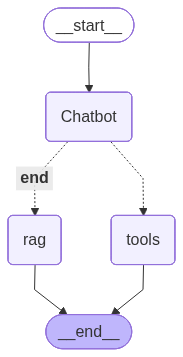

In [211]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

graph=StateGraph(State)

## node
graph.add_node("Chatbot",chatbot)
graph.add_node("tools", ToolNode(tools))
graph.add_node("rag",rag)

## Edges
graph.add_edge(START,"Chatbot")
graph.add_conditional_edges(
    "Chatbot",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
    {
        'tools': "tools",         # if condition returns True -> tools
        '__end__': "rag"   # if condition returns False -> AnotherNode
    }
)
graph.add_edge('tools',END)
graph.add_edge('rag',END)
graph_builder=graph.compile(checkpointer=memory)


## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [212]:
## Invocation

config = {"configurable": {"thread_id": "1"}}

out=graph_builder.invoke({'messages':"summary of the report"},config)


response from chatbot -- content='I’m happy to help, but I need a bit more information. Could you let me know which report you’d like summarized (e.g., its title, subject, or a copy of the text)? Once I have the report details, I can provide a concise summary for you.' additional_kwargs={'reasoning_content': 'The user says "summary of the report". We need context: There\'s no prior conversation. Likely they want a summary of some report, but we don\'t have the report content. Maybe they refer to some report we have? Could be they want a summary of a report we have in the system? There\'s no attached file. Might need to ask for clarification. But maybe they expect a generic answer? Could ask which report. Probably need to ask for more details.'} response_metadata={'token_usage': {'completion_tokens': 160, 'prompt_tokens': 151, 'total_tokens': 311, 'completion_time': 0.333900159, 'prompt_time': 0.007727242, 'queue_time': 0.042674268, 'total_time': 0.341627401}, 'model_name': 'openai/gpt-

In [215]:
print(out['messages'][-1].content)

**Summary of the Gemma Model Report**

| Aspect | Key Points |
|--------|------------|
| **Purpose & Scope** | The report documents the development, evaluation, and responsible‑use considerations for the Gemma family of open‑source language models (2 B and 7 B parameters). |
| **Model Architecture** | Gemma builds on the same research and technology that powers Google’s Gemini models, delivering state‑of‑the‑art performance in a lightweight package. |
| **Training Data** | • Rigorous data‑filtering pipelines were applied to remove personal information, other sensitive content, and benchmark data that could bias evaluation.<br>• The final training corpus is a curated mix of publicly available text, filtered for quality and safety. |
| **Performance** | • Benchmarks show best‑in‑class results for models of this size across a range of language‑understanding and generation tasks.<br>• Detailed performance tables (accuracy, perplexity, etc.) are provided in the full report. |
| **Safety & R